# Control & Learning

This chapter explains key ideas in applications of learning to control.  The topics are

* Introduction to Control
* Parametric Control
* Dynamic Programming
* Value Iteration
* Policy Iteration
* Reinforcement Learning

Here are a few examples of control applications:

![title](Figures/control1.pdf)


## Introduction to Control

In a control problem, 

* there is a system to which one can apply some actions
* control = Choosing actions over time (one-time = decision, multiple-time = control)
* each action has a cost and consequences
* consequences: impact on current and future costs and rewards
* often, one observes some effect of the actions (e.g., state and output of system)
* many types of control problems: 
-- known/unknown system model; 
-- known/unknown ‘state’

The figure below illustrates a control system:

![title](Figures/control2.pdf)

Learning is used in control when the system is not completely known, which is very often the case.  Another approach for such situations is **adaptive control**.  We will see how adaptive control and learning differ.


## Parametric Control

Consider the situation shown below:
![title](Figures/control3.pdf)

A marble is rolling on a board.  The goal is to adjust the angle $\alpha$ that the board makes with the horizontal
in order to bring back the marble close to the center of the board.  We adjust that angle by observing the position $x$ and velocity $\dot x$ of the marble measured with respect to the center of the board.

Control theory would tell is how to do this, but we don't know anything about that.  So, we choose a parametric control law:

$$ \alpha = f(x, \dot x) = a x + b \dot x$$

where $a$ and $b$ are two constants that we have to select.  Our measure of effectiveness of the control is the cost $C(a, b)$ defined by

$$C(a, b) = \int_0^\infty x^2_t dt.$$

Newton's laws imply that

$$ \ddot x = - g \sin(\alpha)$$

where $g = 9.81m/s^2$.  We use a **brute-force approach** to select $a$ and $b$.  We simulate the system for values of $(a, b)$ in a grid of values shown below:

![title](Figures/control4.pdf)

For each pair of values, we compute the cost.  We then find the values that have the smallest cost. More precisely, our simulation uses the following discrete-time approximation:

$$X(n+1) = X(n) + 0.1*V(n)$$

$$V(n+1) = V(n) - 0.1*9.81*sin(a(n)).$$

In this approximation, a time step is 0.1 second.  The approximation assumes that the velocity and acceleration are constant during intervals of $0.1$ second instead of changing continuously.





We fix the initial conditions $x_0, \dot x_0$ for our simulations and we then try the parameters we found with other initial conditions.  


In [2]:
from IPython.core.display import HTML
from IPython.display import Javascript
#from toggle_cell import toggle_code as hide_code
import numpy as np
import math
import matplotlib
import scipy
from scipy.stats import norm
from scipy.stats import binom
import pandas as pd
params = {'figure.figsize':(12,6), # These are plot parameters
         'xtick.labelsize': 16,
         'ytick.labelsize':16,
         'axes.titlesize':18,
         'axes.labelsize':18,
         'lines.markersize':4,
         'legend.fontsize': 20}
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
matplotlib.rcParams.update(params)
import os
from os.path import isfile, join
import random
from ipywidgets import *
import pandas as pd
import cv2

IMG = 'Original'

print('Libraries loaded successfully')

Libraries loaded successfully


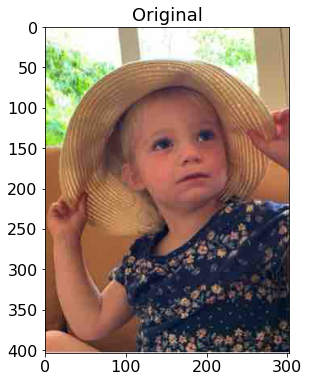

To see different versions of the image, select one by running next cell and run this cell again.
Sorry again for this two-step process.  Hopefully, someone will fix Jupyter Book.


In [3]:
from PIL import Image
import requests
from io import BytesIO
path = 'https://raw.githubusercontent.com/jeanwalrand/Notes_on_AI/main/'

def getImage(name):
    response = requests.get(path+name)
    im1 = Image.open(BytesIO(response.content))
    im2 = np.array(im1)
    return im2
    
img0 = getImage("Melanie.jpg")
kernel = np.ones((3, 3), np.float32) / 9
imgGray0 = cv2.cvtColor(img0,cv2.COLOR_RGB2GRAY)
imgBlur0 = cv2.GaussianBlur(imgGray0,(7,7),0)
imgCanny0 = cv2.Canny(img0,150,200)
imgDilation0 = \
cv2.dilate(imgCanny0,kernel,iterations=1)
imgEroded0 = \
cv2.erode(imgDilation0,kernel,iterations=1)
imgCropped0 = img0[60:250,90:230]

def showImage(IMG):
    captions = ['Original','Gray', 'Blur','Canny', \
                'Dilation', 'Eroded','Cropped']
    images = [img0,imgGray0,imgBlur0,imgCanny0, \
              imgDilation0, imgEroded0, imgCropped0]
    image = images[captions.index(IMG)]
    plt.imshow(image, cmap = plt.cm.gray)
    plt.title(IMG)
    plt.show()
    
showImage(IMG)

print('To see different versions of the image, select one by running next cell and run this cell again.')
print('Sorry again for this two-step process.  Hopefully, someone will fix Jupyter Book.')

In [4]:
def dummy(IMGd):
    global IMG
    IMG = IMGd

IMG = widgets.RadioButtons(
    options=['Original', 'Gray', 'Blur','Canny',\
             'Dilation','Eroded','Cropped'],
    value='Original', # Defaults to 'pineapple'
    layout={'width': 'max-content'}, 
    # If the items' names are long
    #description='Pizza topping:',
    disabled=False
)
z = widgets.interactive(dummy, IMGd=IMG)
display(z)



interactive(children=(RadioButtons(description='IMGd', layout=Layout(width='max-content'), options=('Original'…

## Object Detection

To detect objects in an image, many algorithms compute local gradients.

The **Canny edge detector** above computes the gradients of the image in different directions and thresholds these gradients.  

Another gradient based algorithm is **HOG** (histogram of oriented gradients). HOG computes the horizontal and vertical gradients using kernels $[-1,0,1]$. HOG then divides the image into cells and calculates a histogram of the magnitudes of the gradients in the cells. HOG normalizes the values of these gradients over image blocks (groups of cells) to make them insensitive to local illumination and shadowing. HOG is effective at detecting perdestrians in images and videos.

The **Haar cascades** is a related method for detecting objects.  It is based on the **Haar wavelet** illustrated below.

![title](Figures/Haar.pdf)

By transforming the image with different ‘scaled’ wavelets, one can detect transitions. By doing this in two dimensions, one can identify ‘rectangular’ shapes. The idea is illustrated below.


![title](Figures/haarTransforms.gif)


### Finding Faces in Image

The cell below illustrates this method used to detect faces in an image.



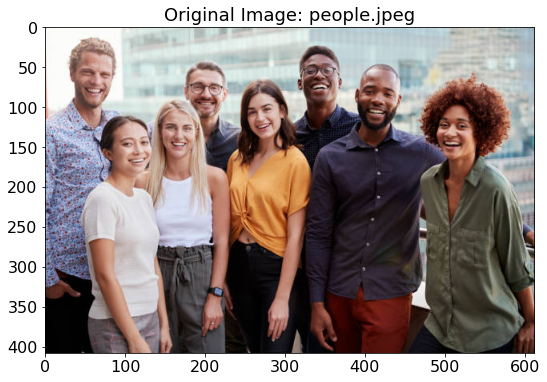

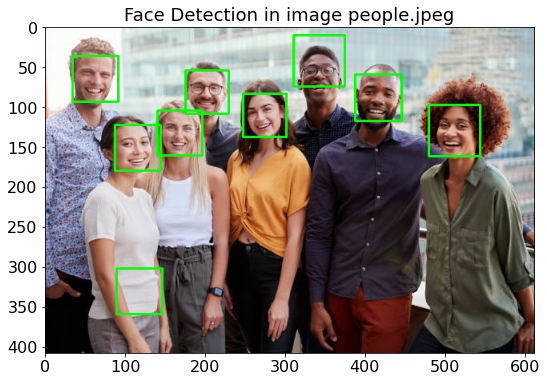

Try changing image_name from people.jpb to people2.jpg
 or people3.jpg then run the cell again.


In [5]:
image_name = "people.jpeg"
def findFaces(image_name):
    image = getImage(image_name)
    plt.imshow(image)
    plt.title('Original Image: '+ image_name)
    plt.show()
    faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    faces = faceCascade.detectMultiScale(gray,1.1,5)
    for (x,y,w,h) in faces:
        cv2.rectangle(image,(x,y),(x+w,y+h),(0,255,0),2)    
    plt.imshow(image)
    plt.title('Face Detection in image '+ image_name)
    plt.show()
    return image, gray, faces
findFaces(image_name)
print('Try changing image_name from people.jpb to people2.jpg')
print(' or people3.jpg then run the cell again.')


### Finding Eyes in Image

Using Haar cascades, one can also find eyes in an image.  We try that below.

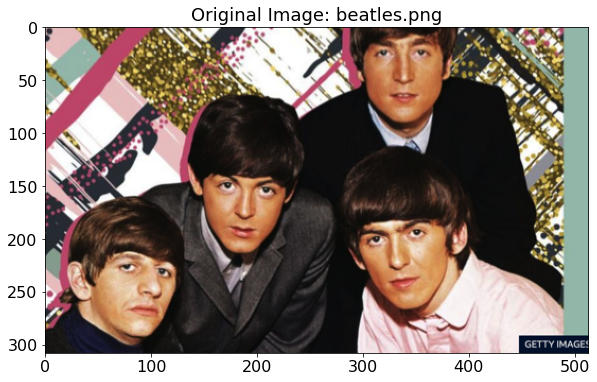

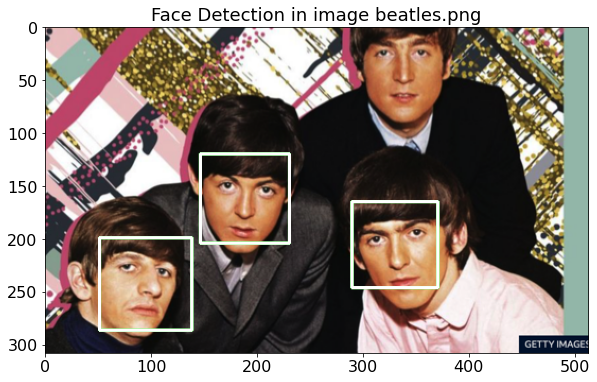

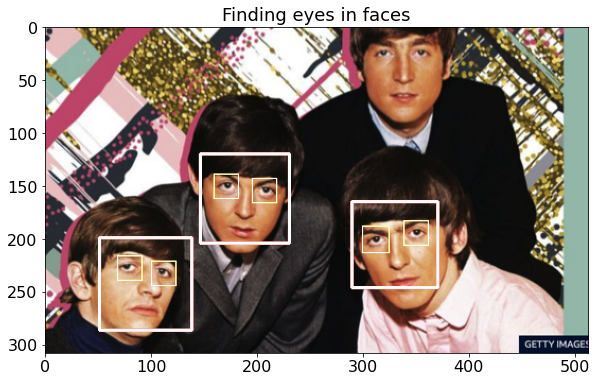

Try replacing image_name by einstein.png, beatles.png, or ralucanu.png


In [6]:

image_name = 'beatles.png' # try 'einstein.png' or 'ralucanu.png'
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
image, gray, faces = findFaces(image_name)
for (x,y,w,h) in faces:
    cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = image[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        if ey < 0.4*h:
            cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(255,255,0),1)

plt.imshow(image)
plt.title('Finding eyes in faces')
plt.show()

print('Try replacing image_name by einstein.png, beatles.png, or ralucanu.png')

### Finding Facial Landmarks

We explain an algorithm that finds 68 facial landmarks, as shown in the figure below.

![title](Figures/68landmarks.pdf)

The algorithm uses **boosted regression trees** that are trained on thousands of labeled images, that is images on which the 68 landmarks have been indicated by hand.  First we explain regression trees, thne boosted trees.

A **regression tree** is an estimation method that roughly works as follows.  Imagine trying to find a rule for estimating the price of houses in Berkeley.  We have a list of sale prices over the last two years. As a first step, we divide the city in two by drawing a red line north-to-south (see picture below) and we find the average price $P_E$ of houses to the east of that line and the average price $P_W$ to the west of that line, as calculated from the recent sales.   Our first estimator is that the price of a house that is to the east of the line is $P_E$ and to the west of the line is $P_W$.  

![title](Figures/berkeley.pdf)


We choose where to draw the line so as to minimize the resulting mean squared error over the available list.  To improve this estimator, we further subdivide the two regions with blue lines as shown in the figure above.  We repeat that step a number of times.  After this process, we have divided the city into rectangles and our estimated price of a house is the average price for the recent sales in the rectangle in which the house is.   

Two observations:

* The process is myopic.  The first subdivision is chosen to minimize the mean squared error as if we did not further subdivide the map, and the same is true for each step. This is for simplicity.  

* Too few steps result in underfitting by overlooking clear trends in the available data.  Too many steps result in overfitting by matching prices of a few houses that may be outliers because of specific features.

**Boosted regression trees** are obtained by computing regression trees for the gradients of the estimators.  Going back to the Berkeley example, let us consider the final estimator.  For each house in our available list, we determine whether the estimated price is too high or too low, and by how much.  This produces a list of $(location, error)$ for each house in the available data.  We then build a regression tree as before for estimating the error as a function of the location.  We then add a small multiple of the new regression tree to the previous one.  This improves our estimator.  Then, as you certainly guessed, we repeat the last step with the new combine estimator, and so on.  

Let us try the algorithm.


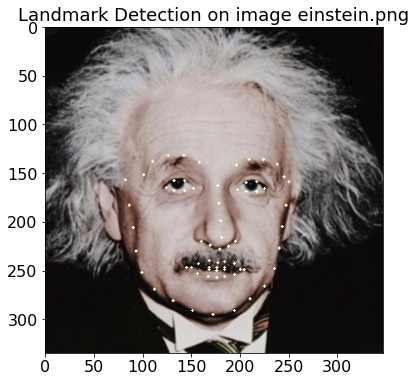

In [10]:
import cv2
import dlib

image_name = 'einstein.png'
image = getImage(image_name)

detector = dlib.get_frontal_face_detector()
#model = requests.get('http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2')

predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

#ret, image = cap.read()
# Convert the image color to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# Detect the face
rects = detector(gray, 1)
# Detect landmarks for each face
for rect in rects:
    # Get the landmark points
    shape = predictor(gray, rect)
# Convert it to the NumPy Array
    shape_np = np.zeros((68, 2), dtype="int")
    for i in range(0, 68):
        shape_np[i] = (shape.part(i).x, shape.part(i).y)
    shape = shape_np

    # Display the landmarks
    for i, (x, y) in enumerate(shape):
    # Draw the circle to mark the keypoint 
        cv2.circle(image, (x, y), 1, (255, 255, 0), -1)
		
# Display the image
plt.imshow(image)
plt.title('Landmark Detection on '+image_name)
plt.show()


## To Run in Real Time

To run face, eye, and landmark detection in real time with your camera, you have to install the software on your computer.  Appendix 2 contains the code for those applications.

## Summary

This chapter covered a number of image processing algorithms.  They are of the *classical programming* type, except for the gradient boosted trees.  Recall the key ideas:

* convolution kernels: local processing of images
* image gradient algorithms for object detection
* Haar wavelets for detecting shapes
* boosted regression trees for finding the location of landmarks